In [1]:

# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(data_dir="../data/", min_ratings=0, max_ratings=None)
    

In [2]:
loader.load_raw()
loader.merge()
df = loader.merged_df

In [3]:
# Calculate and display the proportion of missing values per column
# show only columns with missing values
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False) / df.shape[0]



would_take_again_prop    0.864727
avg_rating               0.221254
avg_difficulty           0.221254
num_ratings              0.221254
pepper                   0.221254
num_online_ratings       0.221254
major                    0.221254
university               0.221254
state                    0.221254
dtype: float64

In [4]:
# Check for logical inconsistencies in gender columns
(df["male"] & df["female"]).sum()


np.int64(2213)

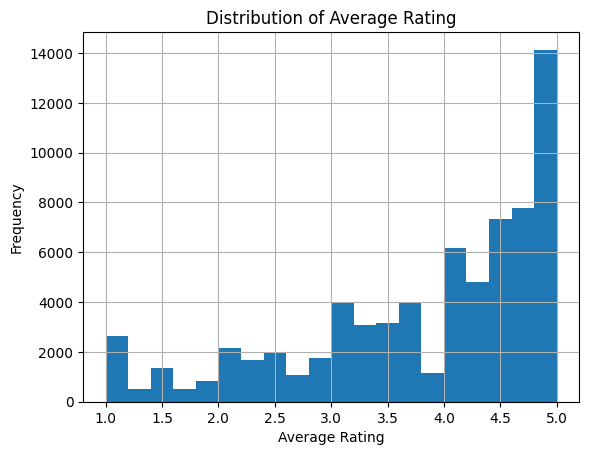

In [5]:
df["avg_rating"].hist(bins=20)
plt.title("Distribution of Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

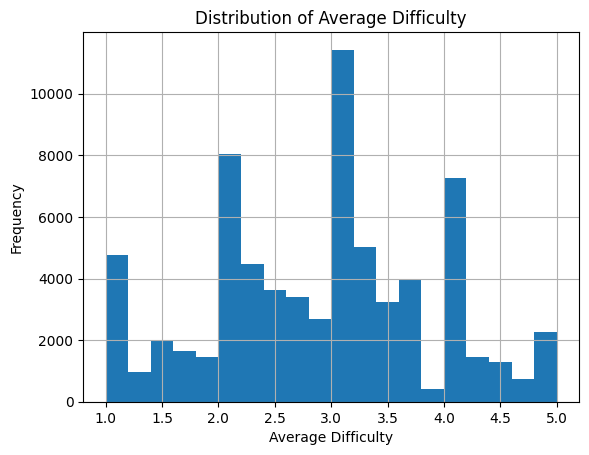

In [6]:
df["avg_difficulty"].hist(bins=20)
plt.title("Distribution of Average Difficulty")
plt.xlabel("Average Difficulty")
plt.ylabel("Frequency")
plt.show()

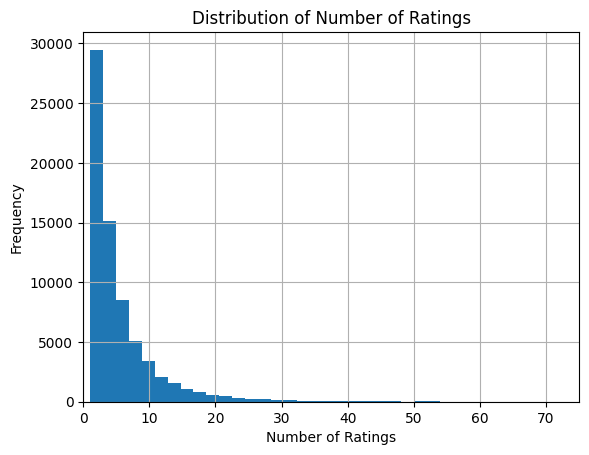

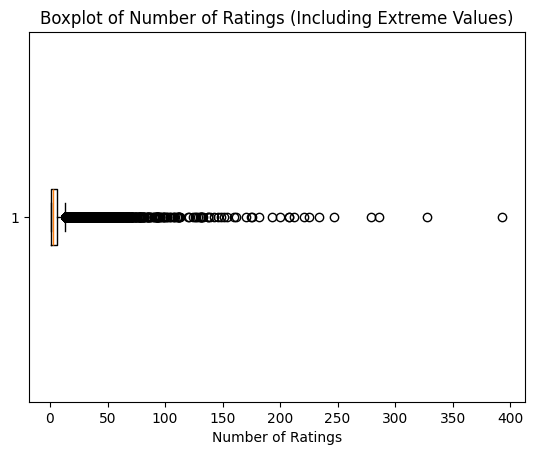

In [7]:
df["num_ratings"].hist(bins=200)
plt.title("Distribution of Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.xlim(0, 75)


plt.figure()
plt.boxplot(df["num_ratings"].dropna(), vert=False)
plt.title("Boxplot of Number of Ratings (Including Extreme Values)")
plt.xlabel("Number of Ratings")
plt.show()


In [8]:
loader.clean()
clean_df = loader.cleaned_df
loader.cleaning_info

# % dropped rows
(len(df) - len(clean_df)) / len(df) * 100, loader.cleaning_info


(24.587282516797934,
 {'dropped_low_rating_count': 19889,
  'dropped_missing_ratings': 0,
  'dropped_inconsistent_gender': 2213})

# Normalization of Tags Relative to Each Professor

From the plots above, it’s clear that the distribution of `number_of_ratings` per professor is highly imbalanced. 
Some instructors have only a handful of reviews, while others have dozens. 
This imbalance makes the raw tag values (which range from 0 to 3) difficult to interpret 
directly -- a “3” does not necessarily mean the same thing for a professor with 5 
reviews as it does for a professor with 40 reviews.

Because the tag values represent intensity rather than literal counts, dividing by num_reviews is not appropriate. 
Instead, we normalize each professor’s tag profile relative to their own total tag intensity. 
This transforms the tag values into a set of within-professor proportions that reflect which tags 
characterize that professor most strongly.

This type of normalization highlights the relative importance of each tag for a given individual. 
The trade-off is that absolute differences between professors are reduced — correlations then 
capture shared patterns in tag emphasis rather than raw magnitude differences.

## Relative Tag Effect Formula

Let

$$
\begin{align*}
& t_{i,j} = \text{raw tag score for professor } i \text{ on tag } j \quad (0, 1, 2, \text{ or } 3) \\
& T_i = \sum_j t_{i,j} = \text{total tag intensity for professor } i
\end{align*}
$$

The **relative tag weight** is:

$$
\text{rel\_tag}_{i,j} = \frac{t_{i,j}}{T_i}
$$

with the convention:

$$
\text{rel\_tag}_{i,j} = 0 \quad \text{if } T_i = 0
$$

This means each tag's score for a professor is normalized by the professor's total tag intensity, and if the total is zero, the relative tag is set to zero.

This transformation ensures that:

- Each professor’s relative tag values lie in \([0,1]\),
- Rows sum to 1 (for professors with at least one non-zero tag),
- Higher tag scores receive proportionally greater weight,
- Differences in review volume no longer distort tag relationships.

The resulting normalized tag matrix captures **patterns** of tag emphasis across 
professors, rather than raw magnitude effects.

/Users/paolacalle/Desktop/NYU/semesters/fall-2025/ds/projects/assessing-professor-effectiveness/ape-capstone/utils/data_loader.py:215: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rel_tags = raw_tags.div(row_sums, axis=0).fillna(0.0)
/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_79519/536024532.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pl1.show()
/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_79519/536024532.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pl2.show()


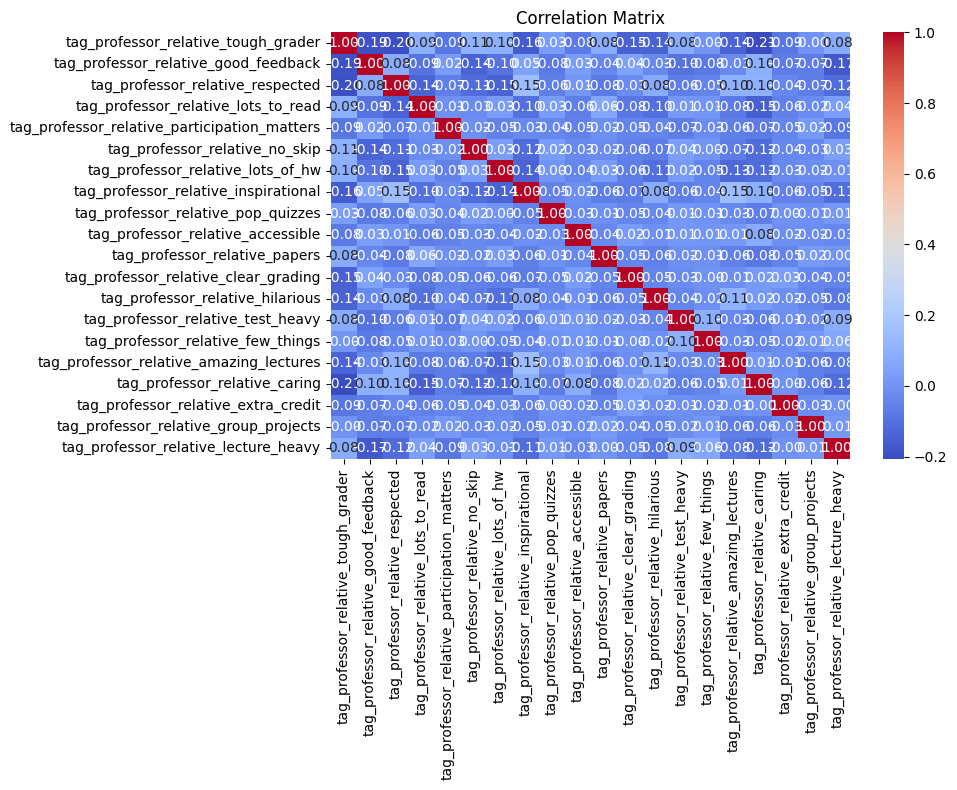

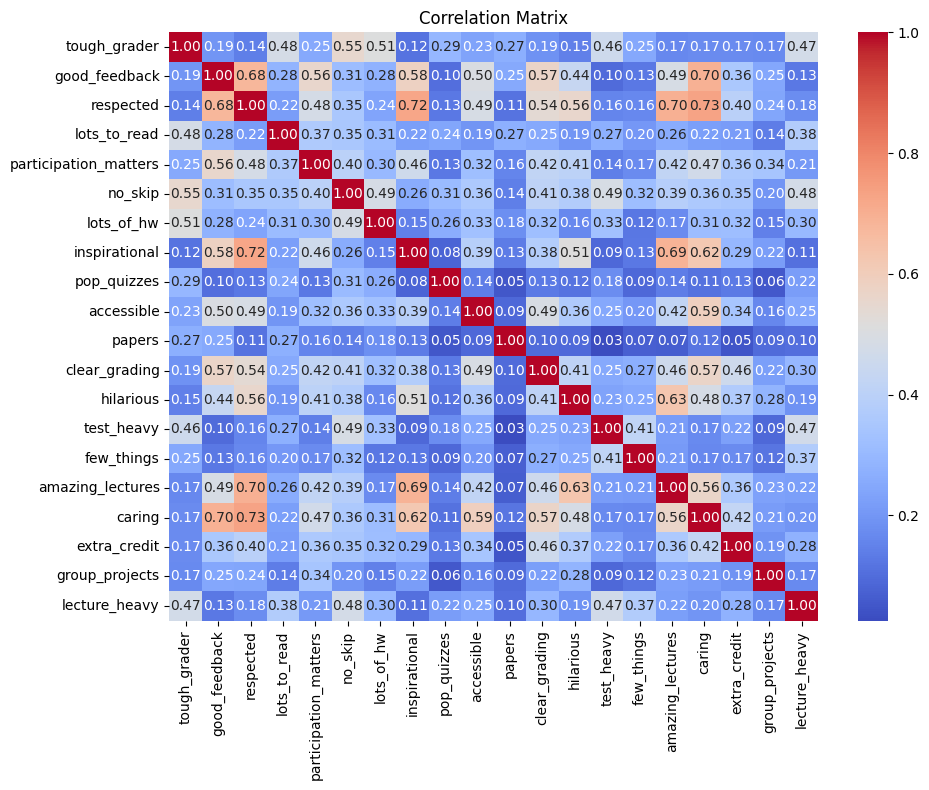

In [9]:
# this adds a column with normalized tag rates
# tag_rate_<tag> = tag_count / num_ratings
loader.add_professor_relative_tag_rates()

# view the correlation of tag rates 
tag_rate_cols = [col for col in loader.prepared_df.columns if col.startswith("tag_professor_relative_")]
pl1, corr_matrix1 = plot_utils.plot_correlation_matrix(loader.prepared_df[tag_rate_cols])

# view tag before rates
tag_cols = loader.tag_cols
pl2, corr_matrix2 = plot_utils.plot_correlation_matrix(loader.prepared_df[tag_cols])
pl1.show()
pl2.show()

In [10]:
res = loader.prepared_df[tag_rate_cols].describe()

# verify range of tag rates
for col in tag_rate_cols:
    print(f"{col}: min={res[col]['min']}, max={res[col]['max']}")

tag_professor_relative_tough_grader: min=0.0, max=1.0
tag_professor_relative_good_feedback: min=0.0, max=1.0
tag_professor_relative_respected: min=0.0, max=1.0
tag_professor_relative_lots_to_read: min=0.0, max=1.0
tag_professor_relative_participation_matters: min=0.0, max=1.0
tag_professor_relative_no_skip: min=0.0, max=1.0
tag_professor_relative_lots_of_hw: min=0.0, max=1.0
tag_professor_relative_inspirational: min=0.0, max=1.0
tag_professor_relative_pop_quizzes: min=0.0, max=1.0
tag_professor_relative_accessible: min=0.0, max=1.0
tag_professor_relative_papers: min=0.0, max=1.0
tag_professor_relative_clear_grading: min=0.0, max=1.0
tag_professor_relative_hilarious: min=0.0, max=1.0
tag_professor_relative_test_heavy: min=0.0, max=1.0
tag_professor_relative_few_things: min=0.0, max=1.0
tag_professor_relative_amazing_lectures: min=0.0, max=1.0
tag_professor_relative_caring: min=0.0, max=1.0
tag_professor_relative_extra_credit: min=0.0, max=1.0
tag_professor_relative_group_projects: min=0

In [11]:
loader.prepared_df[tag_cols].describe()

for col in tag_cols:
    print(f"{col}: min={loader.prepared_df[col].min()}, max={loader.prepared_df[col].max()}")

tough_grader: min=0, max=112
good_feedback: min=0, max=171
respected: min=0, max=186
lots_to_read: min=0, max=82
participation_matters: min=0, max=82
no_skip: min=0, max=110
lots_of_hw: min=0, max=141
inspirational: min=0, max=119
pop_quizzes: min=0, max=97
accessible: min=0, max=63
papers: min=0, max=64
clear_grading: min=0, max=77
hilarious: min=0, max=224
test_heavy: min=0, max=81
few_things: min=0, max=39
amazing_lectures: min=0, max=136
caring: min=0, max=127
extra_credit: min=0, max=128
group_projects: min=0, max=92
lecture_heavy: min=0, max=38


In [12]:
# show columns that highly correlate with each other in tag rates
highly_correlated_threshold = 0.5
highly_correlated_res_1 = defaultdict(list)

for col in corr_matrix1.columns:
    high_corrs = corr_matrix1[col][(corr_matrix1[col].abs() > highly_correlated_threshold) & (corr_matrix1[col].abs() < 1.0)]
    for other_col, corr_value in high_corrs.items():
        highly_correlated_res_1[col].append((other_col, corr_value))
        
print(highly_correlated_res_1)
len(highly_correlated_res_1)

defaultdict(<class 'list'>, {})


0

In [13]:
# show columns that highly correlate with each other in tag rates
highly_correlated_threshold = 0.5
highly_correlated_res_2 = defaultdict(list)

for col in corr_matrix2.columns:
    high_corrs = corr_matrix2[col][(corr_matrix2[col].abs() > highly_correlated_threshold) & (corr_matrix2[col].abs() < 1.0)]
    for other_col, corr_value in high_corrs.items():
        highly_correlated_res_2[col].append((other_col, corr_value))
        
print(highly_correlated_res_2)
len(highly_correlated_res_2)

defaultdict(<class 'list'>, {'tough_grader': [('no_skip', 0.5536375299347145), ('lots_of_hw', 0.5108529192174589)], 'good_feedback': [('respected', 0.6777944379881019), ('participation_matters', 0.5581603956162007), ('inspirational', 0.581605370539744), ('clear_grading', 0.5687788135381686), ('caring', 0.6952000812014231)], 'respected': [('good_feedback', 0.6777944379881019), ('inspirational', 0.7226394643808476), ('clear_grading', 0.5380241628787117), ('hilarious', 0.558006667166881), ('amazing_lectures', 0.6967576053046477), ('caring', 0.7325576581996481)], 'participation_matters': [('good_feedback', 0.5581603956162007)], 'no_skip': [('tough_grader', 0.5536375299347145)], 'lots_of_hw': [('tough_grader', 0.5108529192174589)], 'inspirational': [('good_feedback', 0.581605370539744), ('respected', 0.7226394643808476), ('hilarious', 0.513994743433248), ('amazing_lectures', 0.6880405472573956), ('caring', 0.6230261855529521)], 'accessible': [('caring', 0.5894566387824596)], 'clear_grading'

12

## Why your correlations collapse after normalization

Before normalization, the tag features looked correlated because they shared a common source of variation: Professors with more reviews had higher tag scores across the board. That artificially inflates correlations between tags.

The problem with this method however is that it removes any shared semantic structure, so we will not use this method.




# Column-wise Z-score Standardization

Z-score standardization takes each tag column and transforms it so that:
- its mean becomes 0,
- its standard deviation becomes 1,
- but the shape of the data stays the same.

Z-score standardization re-scales each tag feature so they are comparable, 
eliminating scale biases while preserving the structure needed to compute 
meaningful tag-to-tag correlations.


## Why standardization is perfect for correlation analysis
Correlation measures co-variation, not absolute magnitude.

But raw tag intensities (0–3) have problems:
- some tags are used more often
- some tags rarely appear but spike in specific professors
- tags with higher variance dominate the correlation matrix
- tags with lower variance look artificially unrelated

Z-scoring fixes this by:
- putting all tags on the same scale
- keeping the pattern of co-movement intact
- removing scale bias


## Why this method keeps correlations meaningful
Unlike the per-professor normalization you tried earlier (which forced each row to sum to 1), 
z-scoring does NOT destroy variance.

Instead, it:
- preserves the absolute differences between professors
- preserves the relative differences between tags
- preserves covariance
- preserves structure


In [19]:
loader.add_column_zscores_standardized(columns = loader.tag_cols)
df_zscores = loader.prepared_df[[col for col in loader.prepared_df.columns if col.startswith("zscore")]]
df_zscores.describe()

# verify scaling
for col in df_zscores.columns:
    print(f"{col}: mean={df_zscores[col].mean()}, std={df_zscores[col].std()}, min={df_zscores[col].min()}, max={df_zscores[col].max()}")

zscore_tough_grader: mean=-3.354088736439476e-18, std=1.0000073758007355, min=-0.4385861589724658, max=50.140216646065234
zscore_good_feedback: mean=-5.701950851947108e-17, std=1.0000073758007355, min=-0.4660134066683964, max=61.27333322190198
zscore_respected: mean=3.5217931732614494e-17, std=1.0000073758007355, min=-0.3767587550751488, max=77.56848116185672
zscore_lots_to_read: mean=-3.8572020469053974e-17, std=1.0000073758007355, min=-0.4054334606451091, max=44.76644604638646
zscore_participation_matters: mean=-5.0311331046592134e-18, std=1.0000073758007355, min=-0.45196390199510894, max=41.48093824328598
zscore_no_skip: mean=-1.3416354945757903e-17, std=1.0000073758007355, min=-0.41994493959170287, max=54.06913492888523
zscore_lots_of_hw: mean=-1.8447488050417117e-17, std=1.0000073758007355, min=-0.3836945263984724, max=69.4734849818281
zscore_inspirational: mean=4.066832592932864e-17, std=1.0000073758007355, min=-0.3137948478259411, max=65.40406323157241
zscore_pop_quizzes: mean=-

/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_79519/1183768681.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pl3.show()


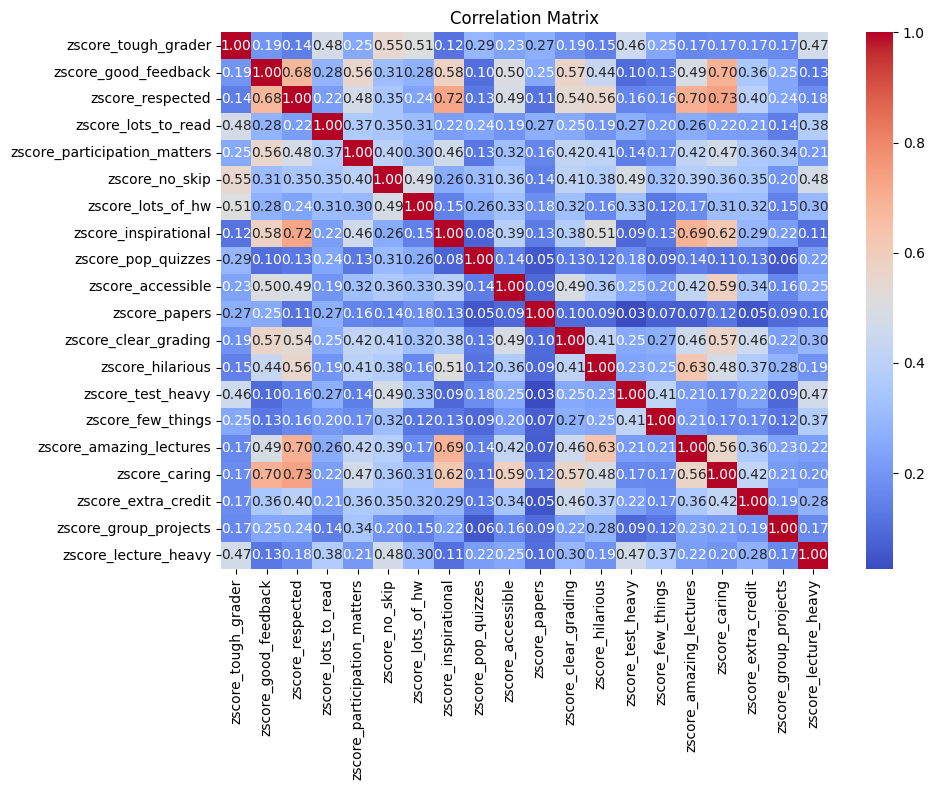

In [17]:
pl3, corr_matrix3 = plot_utils.plot_correlation_matrix(df_zscores)
pl3.show()